# 1. 데이터 임베딩


In [1]:
import json
import numpy as np
import re
from sentence_transformers import SentenceTransformer

# === 파일 경로 설정 ===
json_file_path = "notebook/data/llm_output[0:1486].json"  # JSON 파일 경로
embedding_save_path = "book_embeddings.npz"  # 임베딩 저장 경로

# === 모델 로드 ===
# Sentence-BERT 모델을 로드합니다. 필요에 따라 모델을 변경할 수 있습니다.
model = SentenceTransformer('all-MiniLM-L6-v2')

# === JSON 데이터 로드 ===
def load_book_data(json_file_path):
    """
    JSON 파일에서 책 데이터를 로드합니다.
    """
    with open(json_file_path, 'r', encoding='utf-8') as file:
        book_data = json.load(file)
        book_data = list(book_data.values())
    return book_data

# === 책 소개글 임베딩 ===
def embed_book_descriptions(book_data, model):
    """
    책 데이터의 소개글을 임베딩합니다.
    """

    messages = [book["message"] for book in book_data]
    hashtags = [re.findall(r'#(\S+)', book["hashtags"]) for book in book_data]

    # print(f"{len(messages) = }")
    # print(f"{len(hashtags) = }")
    # print(f"{hashtags}")

    book_content = [
        f"{message} {' '.join(tags)}" for message, tags in zip(messages, hashtags)
    ]
    # print(len(book_content))
    # print(book_content)

    embeddings = model.encode(messages, show_progress_bar=True)
    return embeddings

# === 임베딩 및 데이터 저장 ===
def save_embeddings(book_data, embeddings, save_path):
    """
    책 데이터와 임베딩 결과를 저장합니다.
    """
    ids = [book["isbn13"] for book in book_data]
    np.savez_compressed(save_path, ids=ids, embeddings=embeddings)

# === 실행 ===
if __name__ == "__main__":
    # 책 데이터를 로드합니다.
    book_data = load_book_data(json_file_path)
    
    # 책 소개글을 임베딩합니다.
    print("Embedding book content...")
    embeddings = embed_book_descriptions(book_data, model)

    # 임베딩 결과를 저장합니다.
    print(f"Saving embeddings to {embedding_save_path}...")
    save_embeddings(book_data, embeddings, embedding_save_path)

    print("Embedding and saving complete.")

/opt/anaconda3/envs/mecab_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding book content...


Batches: 100%|██████████| 47/47 [00:04<00:00, 11.59it/s]

Saving embeddings to book_embeddings.npz...
Embedding and saving complete.


In [2]:
import numpy as np

# === 임베딩 로드 함수 ===
def load_embeddings(file_path):
    """
    npz 파일에서 저장된 임베딩과 관련 데이터를 로드합니다.
    """
    # 저장된 데이터를 불러옴
    data = np.load(file_path, allow_pickle=True)
    ids = data['ids']  # ISBN 또는 기타 ID
    embeddings = data['embeddings']  # 임베딩 벡터
    return ids, embeddings

# === 로드 및 사용 ===
if __name__ == "__main__":
    embedding_save_path = "book_embeddings.npz"  # 저장된 파일 경로

    # 임베딩 데이터를 로드합니다.
    ids, embeddings = load_embeddings(embedding_save_path)

    # 결과 출력
    print(f"Loaded {len(ids)} ids.")
    print(f"Loaded {len(embeddings)} embeddings.")
    print(f"First ID: {ids[0]}")
    print(f"First embedding shape: {embeddings[0].shape}")
    print(f"First embedding vector: {embeddings[0]}")

Loaded 1486 ids.
Loaded 1486 embeddings.
First ID: 139791169851053
First embedding shape: (384,)
First embedding vector: [-3.87459695e-02  1.10872068e-01  5.34427688e-02 -3.42537612e-02
  4.77484986e-02 -5.37737161e-02  1.47102386e-01  2.63079721e-02
 -4.66099866e-02 -8.63951370e-02  8.94806534e-02  5.14824577e-02
  1.09533481e-01 -3.24588045e-02  4.05661464e-02 -6.84233531e-02
  6.10725917e-02  4.49792072e-02 -1.07170671e-01 -3.77559923e-02
  8.15830827e-02 -5.73653467e-02  1.80438510e-03  3.35770622e-02
 -7.27418438e-02 -2.44037323e-02 -9.52424482e-03 -2.77405139e-02
 -2.51716692e-02  1.82211250e-02 -4.58498895e-02  3.41203958e-02
  3.18457447e-02 -7.71623291e-03 -9.50520188e-02 -4.88419048e-02
 -2.17166729e-02 -2.70715244e-02 -7.19275102e-02  8.92762840e-02
 -1.44997686e-01 -1.26593322e-01  5.01048081e-02 -3.31596360e-02
  6.31344318e-02  4.19111922e-02 -7.56181255e-02 -1.24472149e-01
 -1.01099089e-02  6.53925585e-03 -1.21257417e-01 -6.09642044e-02
  3.52943763e-02 -1.04850054e-01  

# 2. Thompson Sampling

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import beta


book_embeddings = embeddings
# books = [f"Book {i}" for i in range(len(ids))]
books = [f"Book {i}" for i in range(len(ids))]  # books는 ids의 길이에 따라 생성
assert len(books) == len(ids), "Books length mismatch with IDs!"
num_books = 1486
# === 클러스터링 ===

# KMeans 클러스터링 (50개의 클러스터로 나눔)
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(book_embeddings)

# 각 클러스터의 책 인덱스 저장
cluster_to_books = {i: [] for i in range(num_clusters)}
for idx, cluster_id in enumerate(clusters):
    cluster_to_books[cluster_id].append(idx)

# 클러스터별 알파, 베타 값 초기화
alpha = np.ones(num_books)
beta_values = np.ones(num_books)

# 이미 제시된 책을 저장할 세트
presented_books = set()



In [4]:
print(len(ids))
print(len(books))

print(f"Length of ids: {len(ids)}")
print(f"Length of embeddings: {len(book_embeddings)}")

1486
1486
Length of ids: 1486
Length of embeddings: 1486


In [5]:
def thompson_sampling(alpha, beta_values):
    """
    Thompson Sampling을 수행하여 각 책의 확률 값을 샘플링.
    """
    return np.random.beta(alpha, beta_values)

def select_books(cluster_to_books, alpha, beta_values, presented_books):
    """
    클러스터 기반으로 책 쌍 선택.
    - 탐색과 활용의 균형을 맞춰 책을 선택.
    """
    # Thompson Sampling을 통해 각 책의 샘플링 값 계산
    samples = thompson_sampling(alpha, beta_values)

    # 클러스터별 대표 책 선택 (확률 값이 높은 책)
    representative_books = []
    for cluster_id, books_in_cluster in cluster_to_books.items():
        cluster_samples = [(idx, samples[idx]) for idx in books_in_cluster if idx not in presented_books]
        if cluster_samples:
            best_book = max(cluster_samples, key=lambda x: x[1])
            representative_books.append(best_book)

    # 대표 책들 중 가장 높은 샘플링 값을 가진 책 1개 선택
    if not representative_books:
        raise ValueError("No more books to present. All books have been used.")
    
    best_book_a = max(representative_books, key=lambda x: x[1])[0]

    # 탐색을 위해 랜덤한 책 선택
    random_book_b = np.random.choice(
        [idx for idx in range(num_books) if idx not in presented_books and idx != best_book_a]
    )

    # 중복 방지
    presented_books.add(best_book_a)
    presented_books.add(random_book_b)

    return best_book_a, random_book_b

def update_data(choice, book_a, book_b, alpha, beta_values):
    """
    사용자 선택 데이터를 기반으로 베타 분포 업데이트.
    """
    if choice == "a":
        alpha[book_a] += 1
        beta_values[book_b] += 1
    else:
        alpha[book_b] += 1
        beta_values[book_a] += 1

## 클러스터링 시각화

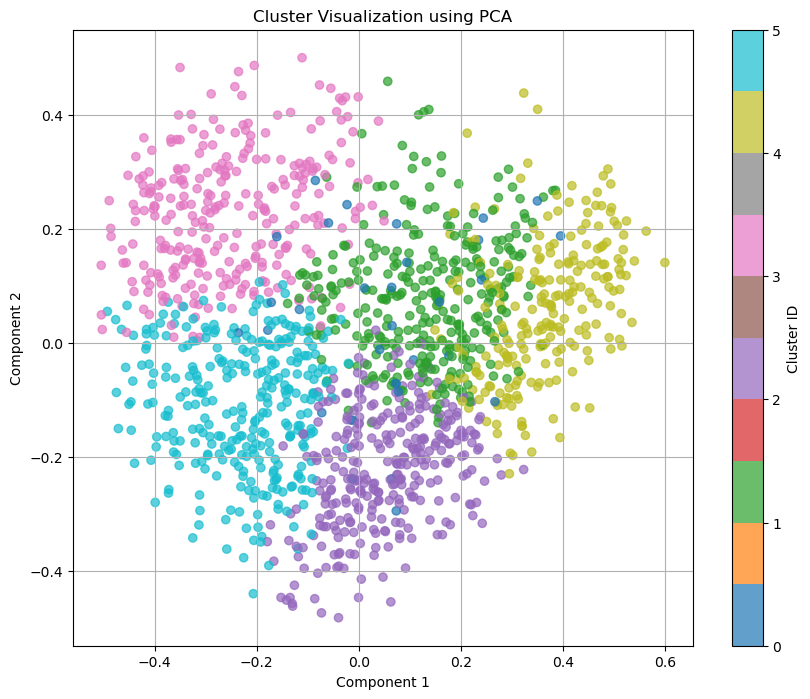

/opt/anaconda3/envs/mecab_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/mecab_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


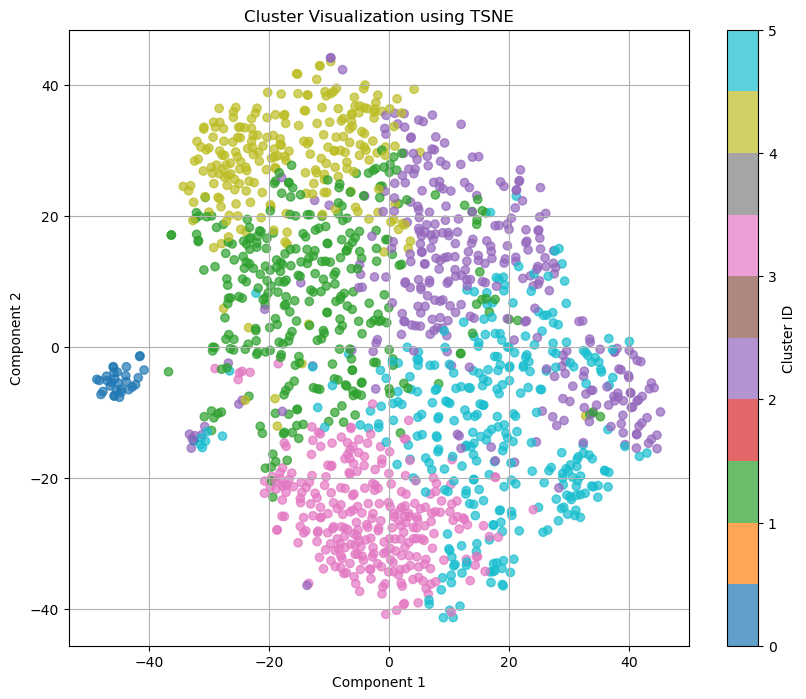

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 클러스터 결과 시각화
def visualize_clusters(embeddings, clusters, method="pca"):
    """
    책 임베딩과 클러스터 결과를 시각화합니다.
    - embeddings: 책 임베딩 (n_samples, n_features)
    - clusters: 클러스터 레이블 (n_samples,)
    - method: 'pca' 또는 'tsne'
    """
    # 차원 축소
    if method == "pca":
        reducer = PCA(n_components=2)  # PCA로 2D 축소
        reduced_embeddings = reducer.fit_transform(embeddings)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        reduced_embeddings = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'.")

    # 시각화
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],  # 첫 번째 축
        reduced_embeddings[:, 1],  # 두 번째 축
        c=clusters,               # 클러스터 ID로 색상 지정
        cmap="tab10",             # 색상 팔레트
        alpha=0.7                 # 투명도
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.title(f"Cluster Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# 사용 예시
visualize_clusters(book_embeddings, clusters, method="pca")  # PCA 사용
visualize_clusters(book_embeddings, clusters, method="tsne")  # t-SNE 사용

In [10]:
# === 메인 루프 ===

def get_message_by_id(ids, book_id, book_data):
    """
    ids와 book_data를 이용해 특정 book_id의 메시지를 조회합니다.
    """
    idx = np.where(ids == book_id)[0][0]  # book_id의 인덱스 찾기
    return book_data[idx]["message"]

for round_num in range(10):
    # 클러스터 기반 책 쌍 선택
    book_a, book_b = select_books(cluster_to_books, alpha, beta_values, presented_books)

    # 책 메시지 조회
    message_a = get_message_by_id(ids, ids[book_a], book_data)
    message_b = get_message_by_id(ids, ids[book_b], book_data)

    # 사용자에게 책 제시
    print('\n')
    print(f"Round {round_num + 1}: Choose between:")
    print(f"a: {message_a}")
    print(f"b: {message_b}")
    
    # 사용자 입력
    choice = input("Enter 'a' or 'b': ").strip().lower()
    if choice not in ['a', 'b']:
        print("Invalid choice. Please enter 'a' or 'b'.")
        continue

    # 데이터 업데이트
    update_data(choice, book_a, book_b, alpha, beta_values)



Round 1: Choose between:
a: “흘러가는 대로, 그저 곁에 있어 줄게.”
b: 사랑은 가벼워지고, 이별은 손쉬워졌다. 익숙함에 상처는 깊어진다.


In [ ]:
# === 최종 추천 ===

# 사용자 선택 데이터를 기반으로 선호 중심 계산
selected_books = np.array(list(presented_books))
selected_embeddings = book_embeddings[selected_books]
weights = np.arange(1, len(selected_books) + 1)  # 가중치 추가
preference_center = np.average(selected_embeddings, axis=0, weights=weights).reshape(1, -1)

# 중심과 유사한 책 추천 (코사인 유사도 기준, 노이즈 추가)
similarities = cosine_similarity(preference_center, book_embeddings).flatten()
noise = np.random.uniform(0, 0.1, size=similarities.shape)  # 랜덤 노이즈 추가
noisy_similarities = similarities + noise
recommended_indices = np.argsort(noisy_similarities)[::-1][:10]

print("\nTop 10 Recommended Books:")
for idx in recommended_indices:
    # 책 ID를 이용해 메시지 조회
    book_id = ids[idx]
    message = get_message_by_id(ids, book_id, book_data)
    print(f"Book ID: {book_id}")
    print(f"Message: {message}\n")